In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Permute,Input,MultiHeadAttention,LayerNormalization, Embedding,Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling,RandomContrast,Add ,MaxPooling2D, GlobalAveragePooling2D, Activation, RandomZoom
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy,SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [ ]:
# # First, navigate to the directory where your repository is located (change 'your_repo' to the actual name of your repository)
# !cd "/content/dataset"

# # Remove all files and directories within the repository
# !rm -r *

# # Navigate back to the root directory if needed
# !cd "/content"

# # Delete the empty repository directory
# !rm -r "dataset"

/bin/bash: line 1: cd: /content/dataset: No such file or directory
^C
rm: cannot remove 'dataset': No such file or directory


# **Kaggle Datast**

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d goelvanshaj/plant-disease-classification-dataset

 99% 1.54G/1.55G [00:16<00:00, 143MB/s]
100% 1.55G/1.55G [00:16<00:00, 98.1MB/s]


In [ ]:
!unzip "/content/plant-disease-classification-dataset.zip" -d "/content/dataset/"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/dataset/dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/43942641-100d-409a-a349-99175f84c629___YLCV_NREC 2938.JPG  
  inflating: /content/dataset/dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/43a32428-0d45-4851-bb62-c1a669854990___YLCV_NREC 2630.JPG  
  inflating: /content/dataset/dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/43a5145b-57e9-4605-8ba3-1fb90f61d460___YLCV_NREC 0108.JPG  
  inflating: /content/dataset/dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/43a73727-237f-40e0-b7e1-95bf4d0eb756___YLCV_GCREC 5343.JPG  
  inflating: /content/dataset/dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/43aae6d1-40ae-42f4-8b71-ae9351683a90___UF.GRC_YLCV_Lab 02661.JPG  
  inflating: /content/dataset/dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/43b2be62-cb86-46f4-9049-92e77d4f335b___YLCV_NREC 0074.JPG  
  inflating: /content/dataset/dataset/train/Tomato___Tom

# **Dataset Fetching**

In [ ]:
train_directory = "/content/dataset/dataset/train"
validation_directory = "/content/dataset/dataset/test"


In [ ]:
CLASS_NAMES = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Cherry_(including_sour)___healthy',
    'Chili__healthy',
    'Chili__leaf curl',
    'Chili__leaf spot',
    'Chili__whitefly',
    'Chili__yellowish',
    'Coffee__Rust',
    'Coffee__healthy',
    'Coffee__red spider mite',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy', 'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape___healthy',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Strawberry___Leaf_scorch',
    'Strawberry___healthy',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]

# **Configuration**

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE":32,
    "IMAGE_SIZE":256,
    "LEARNING_RATE": 0.001,
    "EPOCHS": 20,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":41,
    "PATCH_SIZE":16
}

# **TensorBoad Call**

In [ ]:
pip install -U tensorboard_plugin_profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.1 MB/s eta 0:00:00


In [ ]:
!rm -rf ./logs/

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
LOG_DIR = './logs/' + CURRENT_TIME
METRIC_DIR= './logs/' + CURRENT_TIME  + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1 , profile_batch = '100,132')

# **WandB SetUp**

In [ ]:
! pip install wandb -qU

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Plant-Disease-Dtection", entity="abderrazek")

In [ ]:
wandb.config = {
    "BATCH_SIZE":32,
    "IMAGE_SIZE":256,
    "LEARNING_RATE": 0.001,
    "EPOCHS": 20,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":41,
    "PATCH_SIZE":16
    "CLASS_NAMES":CLASS_NAMES,
}

In [ ]:
CONFIGURATION = wandb.config

In [ ]:
wandb.run

# **Datast Loading**

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)

# **Visualize Data - 1**

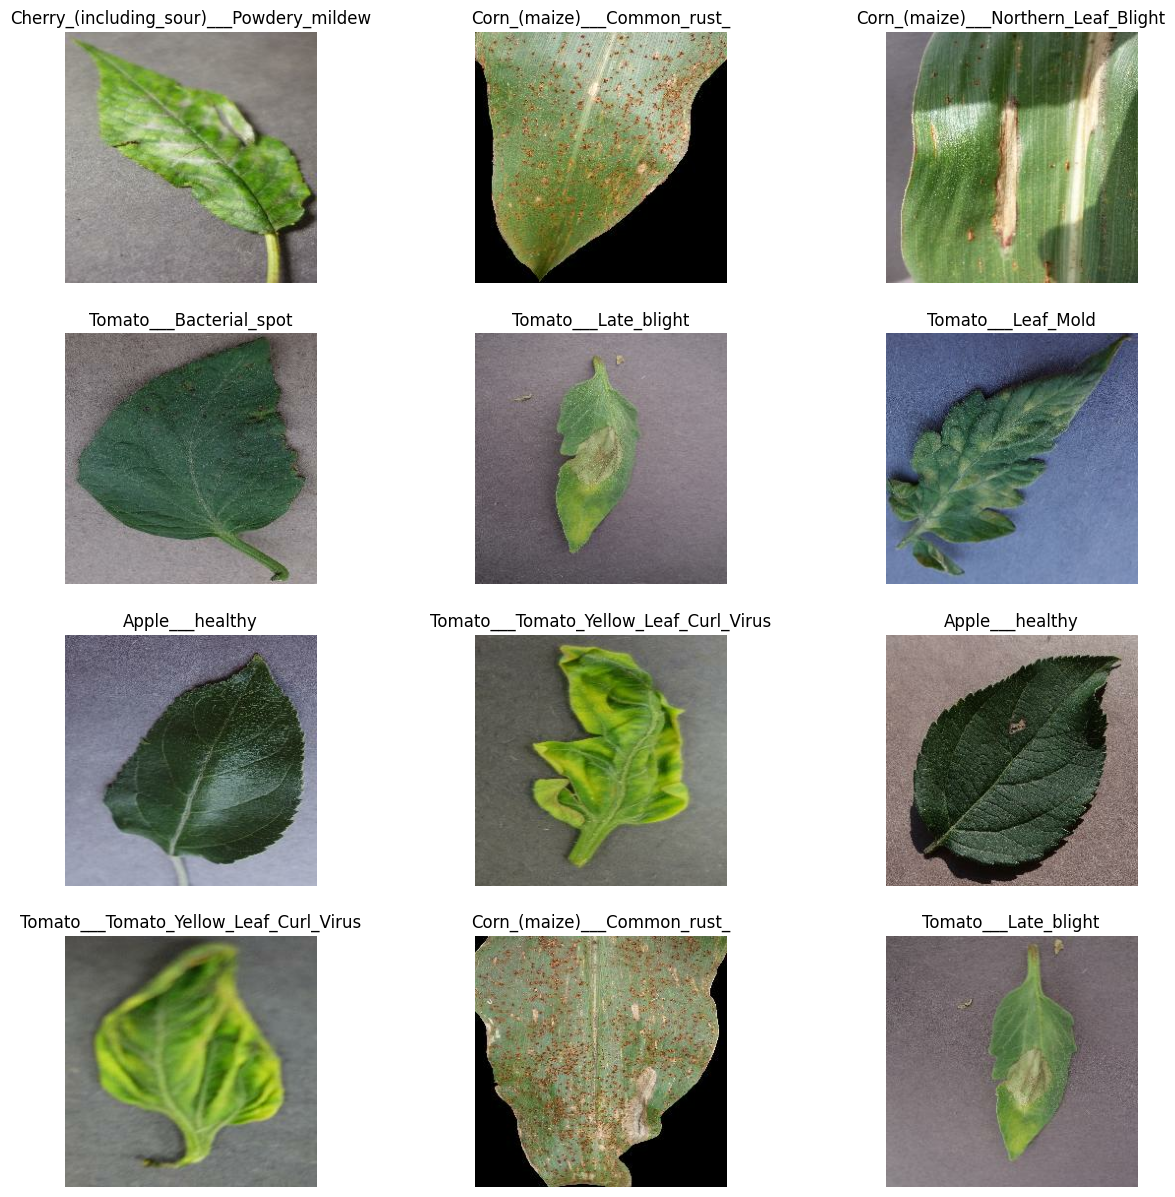

In [ ]:
plt.figure(figsize = (15,15))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4,3, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# **Data Augmentation**

In [ ]:
augment_layers = tf.keras.Sequential(
    [
     RandomRotation(factor = (-0.025, 0.025),),
     RandomFlip(mode='horizontal',),
     RandomContrast(factor=0.1),
    ]
)

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
train_dataset_1 = (train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE))

In [ ]:
training_dataset = train_dataset_1 .prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
training_dataset

# **Visualize Data - 2**

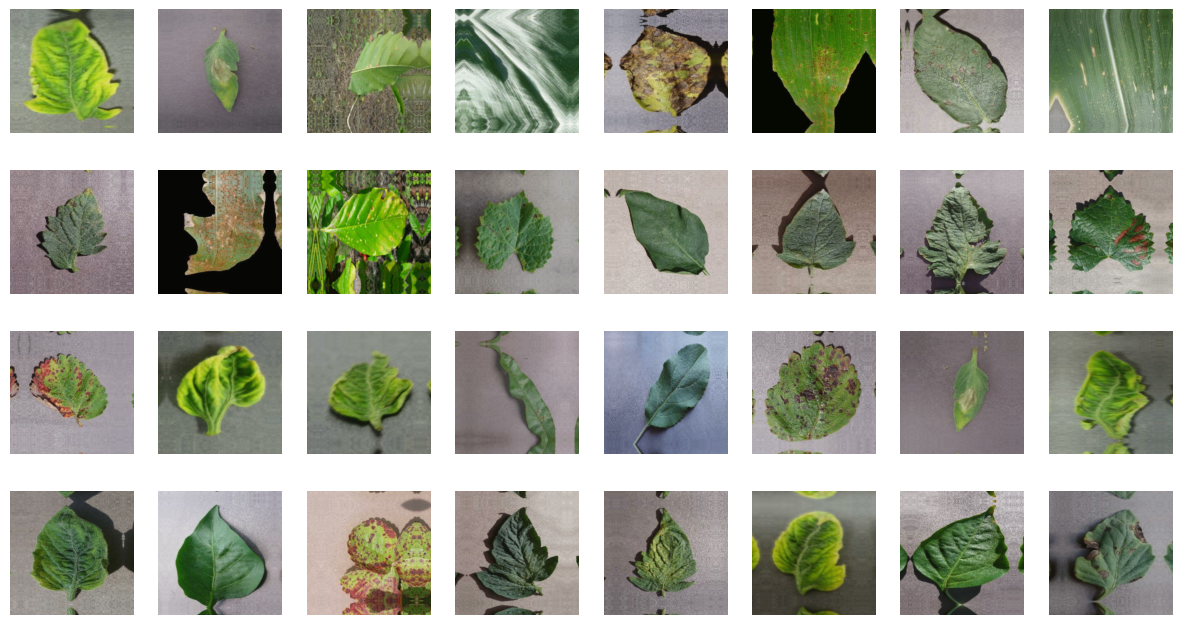

In [ ]:
plt.figure(figsize = (15,8))
for images, labels in mix_train_dataset.take(1):
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[0][i] / 255.)
    plt.axis("off")

# **Extra Layer**

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    Rescaling(1./255)
])

# **WandB CallBacks**

In [ ]:
class LogConfMatrix(CallBack):
  def on_epoch_end(self, epoch, logs):

    predicted = []
    labels = []

    for im, label in val_dataset:
      predicted.append(lenet_model(im))
      labels.append(label)

    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[:-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(y_true = lab, preds = pred, class_names = CONFIGURATION ["CLASS_NAMES"])

    wandb.log({"conf_mat" : cm})

In [ ]:
class LogResultsTable(CallBack):
  def on_epoch_end(self, epoch, logs):

    columns = ["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)

    for im, label in validation_dataset.take(100):
      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

    wandb.log({"Model Results": val_table})

# **efficient Net Model**

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3),
)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_9 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_12 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                      

# **Efficient Net Layers**

In [ ]:
backbone.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in backbone.layers[1:] if is_conv(layer.name) == True]

In [ ]:
feature_map_model = Model(
    inputs = backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]']   

In [ ]:
test_image = cv2.imread("/content/dataset/dataset/test/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG")
test_image = cv2.resize(test_image, (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)


im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 14s 14s/step


In [ ]:
for i in range(len(f_maps)-95):
  plt.figure(figsize = (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]

  joint_maps = np.ones((f_size, f_size*n_channels))

  axis = plt.subplot(len(f_maps),1, i+1)
  for j in range(n_channels):
    joint_maps[:, f_size * j: f_size * (j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")

# **Efficient Net training**

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor = 'accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True,
)

In [ ]:
loss_function = CategoricalCrossentropy(
    from_logits=False,
)

In [ ]:
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k = 2, name='top_k_accuracy') ]

In [ ]:
model.compile(
      optimizer = Adam(learning_rate= CONFIGURATION["LEARNING_RATE"]*10),
      loss = loss_function,
      metrics = metrics,
)

In [ ]:
history = model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs=CONFIGURATION["EPOCHS"],
    verbose = 1,
    callbacks=[checkpoint_callback, tensorboard_callback, WandbCallback(), LogConfMatrix(), LogResultsTable()])

Epoch 1/20
1035/1035 [==============================] - ETA: 0s - loss: 0.7830 - val_accuracy: 0.7783 - top_k_accuracy: 0.8930
Epoch 1: val_accuracy improved from -inf to 0.77832, saving model to best_weights
1035/1035 [==============================] - 415s 377ms/step - loss: 0.7830 - val_accuracy: 0.7783 - top_k_accuracy: 0.8930 - val_loss: 0.6223 - val_val_accuracy: 0.8253 - val_top_k_accuracy: 0.9179
Epoch 2/20
1035/1035 [==============================] - ETA: 0s - loss: 0.4334 - val_accuracy: 0.8617 - top_k_accuracy: 0.9491
Epoch 2: val_accuracy improved from 0.77832 to 0.86168, saving model to best_weights
1035/1035 [==============================] - 411s 396ms/step - loss: 0.4334 - val_accuracy: 0.8617 - top_k_accuracy: 0.9491 - val_loss: 0.3568 - val_val_accuracy: 0.8880 - val_top_k_accuracy: 0.9585
Epoch 3/20
1035/1035 [==============================] - ETA: 0s - loss: 0.3748 - val_accuracy: 0.8828 - top_k_accuracy: 0.9586
Epoch 3: val_accuracy improved from 0.86168 to 0.88279

# **Evaluate model**

In [ ]:
model.evaluate(val_dataset)

261/261 [==============================] - 57s 209ms/step - loss: 0.3638 - val_accuracy: 0.9433 - top_k_accuracy: 0.9815


[0.36379802227020264, 0.9432785511016846, 0.9815325736999512]

In [ ]:
test_image = cv2.imread("/content/360_F_225969749_WMrOvtlxZHGj8fT4QNApuAx0C4qPws6J.jpg")
test_image = cv2.resize(test_image, (256, 256))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)


CLASS_NAMES[tf.argmax(model(im), axis = -1).numpy()[0]]

'Grape___healthy'

# **Confussion Matrix**

In [ ]:
# Initialize empty lists to store predicted classes and labels
predicted = []
labels = []

# Iterate over the validation dataset, where 'val_dataset' contains images and their corresponding labels
for im, label in val_dataset.take(100):
    # Use the model to predict the class of the image and append it to the 'predicted' list
    predicted.append(model(im))

    # Append the true label to the 'labels' list
    labels.append(label)

# Concatenate the true labels and predicted classes to obtain flat arrays
# First, concatenate all labels except the last one and flatten the result
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])

# Concatenate all predicted classes except the last one and flatten the result
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

[[ 62   0   0 ...   0   0   0]
 [  0  49   0 ...   0   0   0]
 [  0   0  23 ...   0   0   0]
 ...
 [  0   0   0 ... 401   0   0]
 [  0   0   0 ...   1  28   0]
 [  0   0   0 ...   0   0 118]]


Text(170.72222222222223, 0.5, 'Predicted')

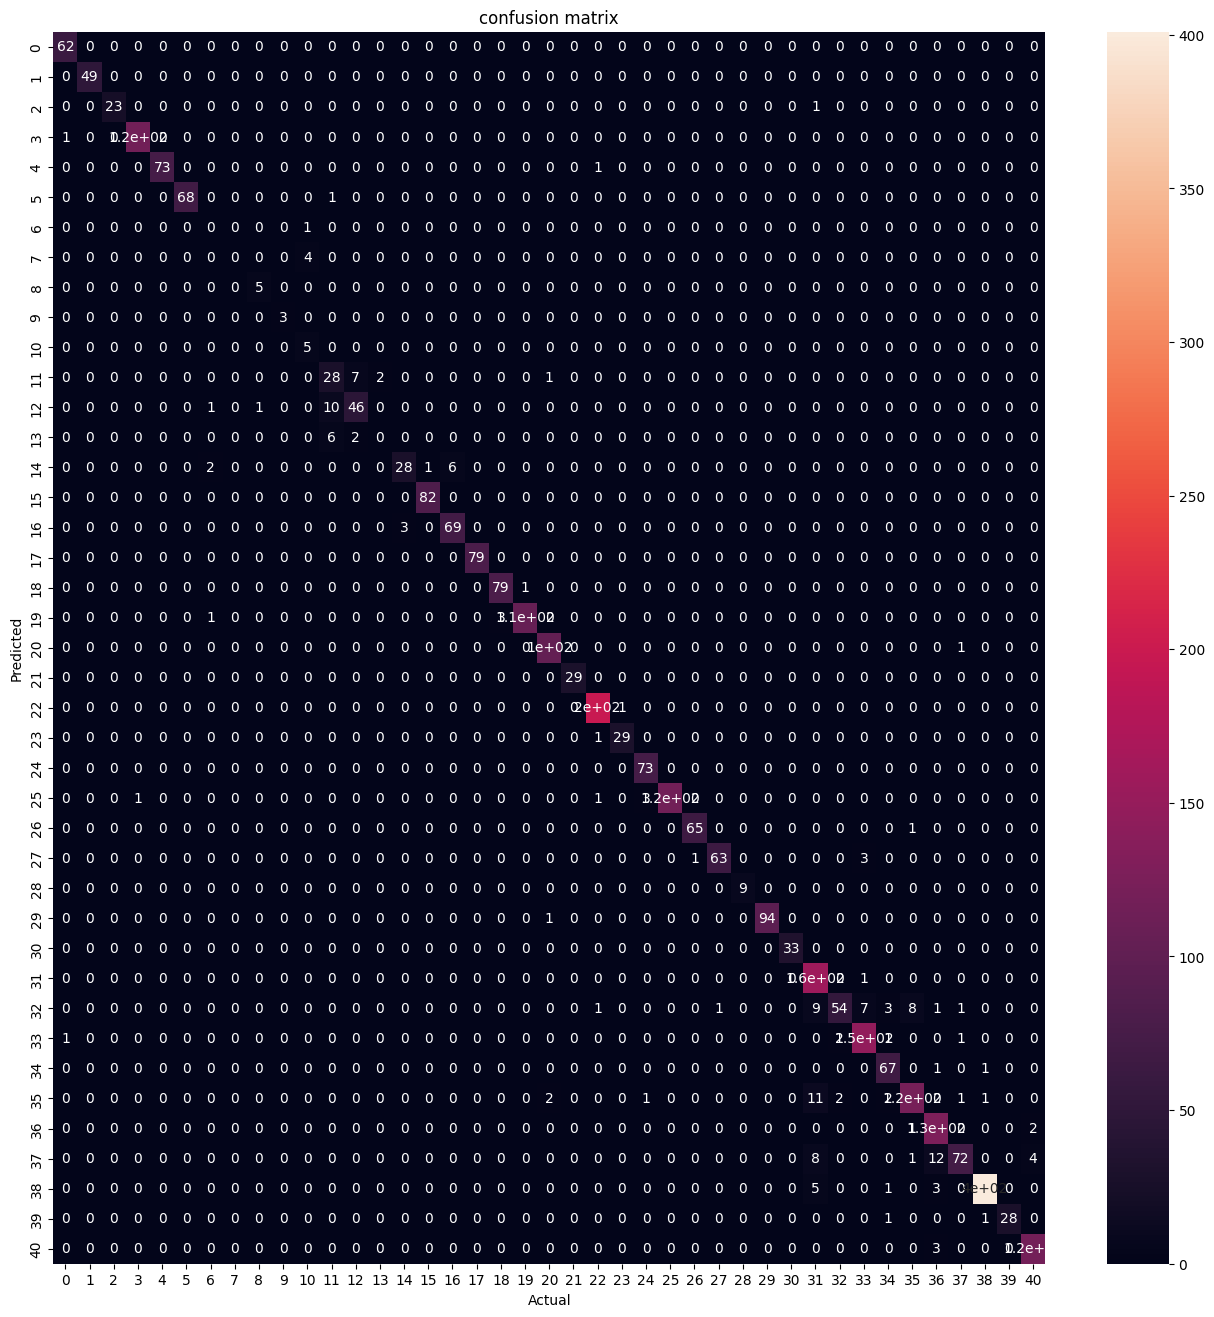

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize = (16,16))
sns.heatmap(cm, annot = True)
plt.title('confusion matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# **TensorBoard**

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir='./logs' --port=8001